## Kaggle "Don't Get Kicked" first model play

**This is a binary classification problem. The most straightforward model comes to my mind is logistic regression.
The Kaggle required to use Gini Index as the evaluation metric. Due to the limited time(a few hours), we just use AUC as the metric, ,since we know Gini Index is relevant to AUC,**

+ The challenge of this competition is to predict if the car purchased at the Auction is a good / bad buy.
+ The dependent variable (IsBadBuy) is binary (C2)
+ There are 32 Independent variables (C3-C34), description of varaibles is in txt file


### Import modules

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
%matplotlib inline

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn import metrics
from collections import OrderedDict

In [2]:
#check working directory
import os
os.getcwd()

'C:\\qiongzhou\\qventus'

### Data Preprocessing and EDA

In [3]:
data = pd.read_csv('training.csv', header=0, sep=',', index_col='RefId')

In [4]:
data.shape

(72983, 33)

In [5]:
data.isnull().sum()

IsBadBuy                                 0
PurchDate                                0
Auction                                  0
VehYear                                  0
VehicleAge                               0
Make                                     0
Model                                    0
Trim                                  2360
SubModel                                 8
Color                                    8
Transmission                             9
WheelTypeID                           3169
WheelType                             3174
VehOdo                                   0
Nationality                              5
Size                                     5
TopThreeAmericanName                     5
MMRAcquisitionAuctionAveragePrice       18
MMRAcquisitionAuctionCleanPrice         18
MMRAcquisitionRetailAveragePrice        18
MMRAcquisitonRetailCleanPrice           18
MMRCurrentAuctionAveragePrice          315
MMRCurrentAuctionCleanPrice            315
MMRCurrentR

+ Obviously most of the data ( > 90%) in the two columns  PRIMEUNIT and  AUCGUART are missing. Nearly 50% data is missing in WheelTypeID and  WheelType.  Given the limited time, for the sake of simplicity. We remove these 4 columns.
+ Common sense tells us that the target (IsBadGuy) might be related to the age of car, manuafaturing year, milages,etc. The Purchase data is not quite relevant compared to other features.  Given the limited time, for now we don't consider "PurchDate"
+ VehYear, VehicleAge are strongly correlated. For now, we remove VehYear, only keep Age in our analysis firstly
+ VNZIP1 are zipcodes, categorical. For the base model we don't consider it for now
+ For other columns, we just drop the missing values.

In [6]:
data.drop(["PRIMEUNIT","AUCGUART","WheelTypeID","WheelType",'PurchDate','VehYear','VNZIP1'], axis=1, inplace=True)
df= data.dropna()

In [7]:
df.dtypes

IsBadBuy                               int64
Auction                               object
VehicleAge                             int64
Make                                  object
Model                                 object
Trim                                  object
SubModel                              object
Color                                 object
Transmission                          object
VehOdo                                 int64
Nationality                           object
Size                                  object
TopThreeAmericanName                  object
MMRAcquisitionAuctionAveragePrice    float64
MMRAcquisitionAuctionCleanPrice      float64
MMRAcquisitionRetailAveragePrice     float64
MMRAcquisitonRetailCleanPrice        float64
MMRCurrentAuctionAveragePrice        float64
MMRCurrentAuctionCleanPrice          float64
MMRCurrentRetailAveragePrice         float64
MMRCurrentRetailCleanPrice           float64
BYRNO                                  int64
VNST      

In [8]:
#numeric features: 'IsBadBuy'is target,'IsOnlineSale'is binary,'VehicleAge' is integer
var_num = [feature for feature in df.columns if df[feature].dtypes !='object']
print (var_num) 

['IsBadBuy', 'VehicleAge', 'VehOdo', 'MMRAcquisitionAuctionAveragePrice', 'MMRAcquisitionAuctionCleanPrice', 'MMRAcquisitionRetailAveragePrice', 'MMRAcquisitonRetailCleanPrice', 'MMRCurrentAuctionAveragePrice', 'MMRCurrentAuctionCleanPrice', 'MMRCurrentRetailAveragePrice', 'MMRCurrentRetailCleanPrice', 'BYRNO', 'VehBCost', 'IsOnlineSale', 'WarrantyCost']


In [9]:
var_categorical = [feature for feature in data.columns if data[feature].dtypes == 'object']
print(var_categorical)

['Auction', 'Make', 'Model', 'Trim', 'SubModel', 'Color', 'Transmission', 'Nationality', 'Size', 'TopThreeAmericanName', 'VNST']


In [10]:
def fill_missing(df,var_num,var_cat):
#     for var in b_num:
#         df[var].fillna(np.mean(df[var]), inplace=True)
    df[var_num] = df[var_num].apply(lambda x: x.fillna(np.mean(x)))
    df[var_cat] = df[var_cat].apply(lambda x: x.fillna(x.value_counts().index[0]))
    return df        

df = fill_missing(data, var_num, var_categorical)

In [11]:
# check if all missing values are gone
df.isnull().sum()

IsBadBuy                             0
Auction                              0
VehicleAge                           0
Make                                 0
Model                                0
Trim                                 0
SubModel                             0
Color                                0
Transmission                         0
VehOdo                               0
Nationality                          0
Size                                 0
TopThreeAmericanName                 0
MMRAcquisitionAuctionAveragePrice    0
MMRAcquisitionAuctionCleanPrice      0
MMRAcquisitionRetailAveragePrice     0
MMRAcquisitonRetailCleanPrice        0
MMRCurrentAuctionAveragePrice        0
MMRCurrentAuctionCleanPrice          0
MMRCurrentRetailAveragePrice         0
MMRCurrentRetailCleanPrice           0
BYRNO                                0
VNST                                 0
VehBCost                             0
IsOnlineSale                         0
WarrantyCost             

In [12]:
# all column names
len(list(df.columns))

26

In [13]:
df.head()

,IsBadBuy,Auction,VehicleAge,Make,Model,Trim,SubModel,Color,Transmission,VehOdo,...,MMRAcquisitonRetailCleanPrice,MMRCurrentAuctionAveragePrice,MMRCurrentAuctionCleanPrice,MMRCurrentRetailAveragePrice,MMRCurrentRetailCleanPrice,BYRNO,VNST,VehBCost,IsOnlineSale,WarrantyCost
RefId,,,,,,,,,,,,,,,,,,,,,
1,0,ADESA,3,MAZDA,MAZDA3,i,4D SEDAN I,RED,AUTO,89046,...,13600.0,7451.0,8552.0,11597.0,12409.0,21973,FL,7100.0,0,1113
2,0,ADESA,5,DODGE,1500 RAM PICKUP 2WD,ST,QUAD CAB 4.7L SLT,WHITE,AUTO,93593,...,12572.0,7456.0,9222.0,11374.0,12791.0,19638,FL,7600.0,0,1053
3,0,ADESA,4,DODGE,STRATUS V6,SXT,4D SEDAN SXT FFV,MAROON,AUTO,73807,...,8457.0,4035.0,5557.0,7146.0,8702.0,19638,FL,4900.0,0,1389
4,0,ADESA,5,DODGE,NEON,SXT,4D SEDAN,SILVER,AUTO,65617,...,5690.0,1844.0,2646.0,4375.0,5518.0,19638,FL,4100.0,0,630
5,0,ADESA,4,FORD,FOCUS,ZX3,2D COUPE ZX3,SILVER,MANUAL,69367,...,8707.0,3247.0,4384.0,6739.0,7911.0,19638,FL,4000.0,0,1020


In [14]:
df['IsBadBuy'].value_counts() # inbalanced data, we might need to be careful to evaluate model later

0    64007
1     8976
Name: IsBadBuy, dtype: int64

+ ### <font color=blue>   Exploratory analysis for numerical columns

In [15]:
#take a look at the numerical columns
df.describe()

,IsBadBuy,VehicleAge,VehOdo,MMRAcquisitionAuctionAveragePrice,MMRAcquisitionAuctionCleanPrice,MMRAcquisitionRetailAveragePrice,MMRAcquisitonRetailCleanPrice,MMRCurrentAuctionAveragePrice,MMRCurrentAuctionCleanPrice,MMRCurrentRetailAveragePrice,MMRCurrentRetailCleanPrice,BYRNO,VehBCost,IsOnlineSale,WarrantyCost
count,72983.000000,72983.000000,72983.000000,72983.000000,72983.000000,72983.000000,72983.000000,72983.000000,72983.000000,72983.000000,72983.000000,72983.000000,72983.000000,72983.000000,72983.000000
mean,0.122988,4.176644,71499.995917,6128.909217,7373.636031,8497.034332,9850.928240,6132.081287,7390.681827,8775.723331,10145.385314,26345.842155,6730.934326,0.025280,1276.580985
std,0.328425,1.712210,14578.913128,2461.689142,2722.156232,3155.896033,3385.371986,2429.308083,2680.445479,3084.025786,3303.102877,25717.351219,1767.846435,0.156975,598.846788
min,0.000000,0.000000,4825.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,835.000000,1.000000,0.000000,462.000000
25%,0.000000,3.000000,61837.000000,4273.000000,5407.000000,6281.000000,7494.000000,4285.000000,5425.000000,6550.000000,7796.000000,17212.000000,5435.000000,0.000000,837.000000
50%,0.000000,4.000000,73361.000000,6098.000000,7305.000000,8446.000000,9790.000000,6076.000000,7328.000000,8753.000000,10114.000000,19662.000000,6700.000000,0.000000,1155.000000
75%,0.000000,5.000000,82436.000000,7765.000000,9021.000000,10650.000000,12088.000000,7732.000000,9006.000000,10897.000000,12308.000000,22808.000000,7900.000000,0.000000,1623.000000
max,1.000000,9.000000,115717.000000,35722.000000,36859.000000,39080.000000,41482.000000,35722.000000,36859.000000,39080.000000,41062.000000,99761.000000,45469.000000,1.000000,7498.000000


(array([1, 2, 3, 4, 5, 6, 7, 8]), <a list of 8 Text xticklabel objects>)

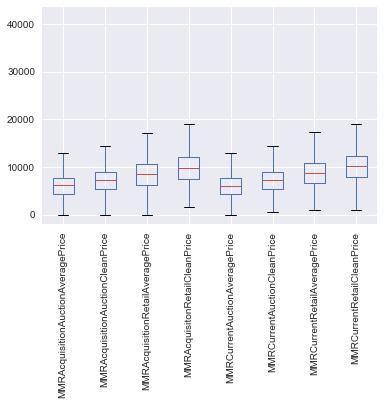

In [16]:
df.boxplot(['MMRAcquisitionAuctionAveragePrice', 'MMRAcquisitionAuctionCleanPrice', 'MMRAcquisitionRetailAveragePrice',\
            'MMRAcquisitonRetailCleanPrice', 'MMRCurrentAuctionAveragePrice', 'MMRCurrentAuctionCleanPrice', \
            'MMRCurrentRetailAveragePrice', 'MMRCurrentRetailCleanPrice'],figsize=(8,12))
plt.xticks(rotation=90)

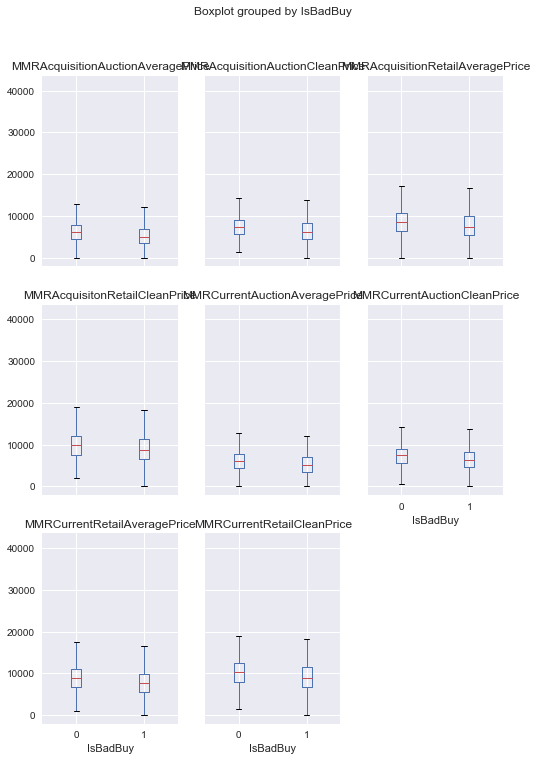

In [17]:
fig1=df.boxplot(['MMRAcquisitionAuctionAveragePrice', 'MMRAcquisitionAuctionCleanPrice', 'MMRAcquisitionRetailAveragePrice',\
            'MMRAcquisitonRetailCleanPrice', 'MMRCurrentAuctionAveragePrice', 'MMRCurrentAuctionCleanPrice', \
            'MMRCurrentRetailAveragePrice', 'MMRCurrentRetailCleanPrice'],by='IsBadBuy',figsize=(8,12))

The boxplot at original scale indicates that there is slight correlation between the variables above and IsBadBuy. There are outliers on each of these 8 columns

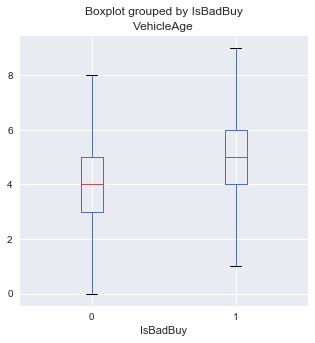

In [18]:
fig2=df.boxplot(['VehicleAge'],by='IsBadBuy',figsize=(5,5)) # strongly relevant to IsBadBuy

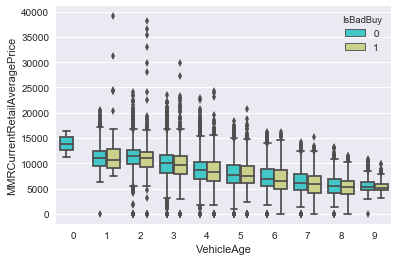

In [19]:
fig3 = sn.boxplot(x='VehicleAge', y="MMRCurrentRetailAveragePrice", hue="IsBadBuy", data=df,palette="rainbow");

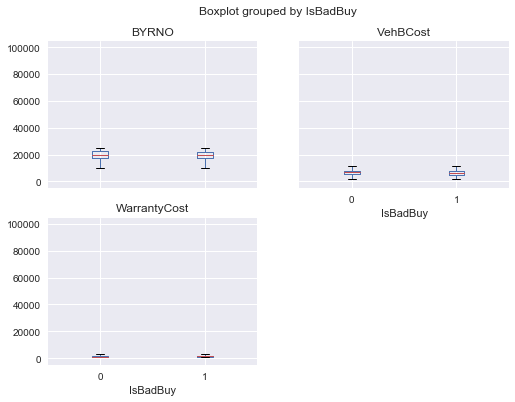

In [20]:
fig4 = df.boxplot(['BYRNO','VehBCost', 'WarrantyCost'],by='IsBadBuy',figsize=(8,6))
#outliers

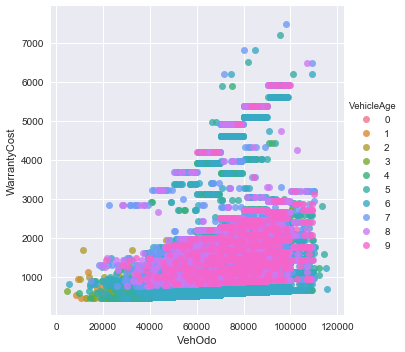

In [21]:
fig5 = sn.lmplot(x='VehOdo',y='WarrantyCost',data=df,fit_reg=False,hue='VehicleAge') 

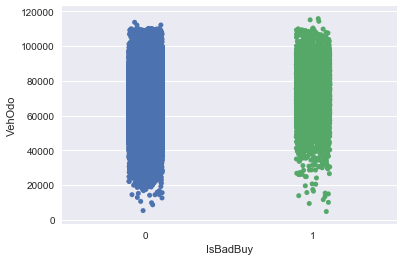

In [22]:
fig6 = sn.stripplot(x="IsBadBuy", y='VehOdo', data=df, jitter=True); 

+ fig2 indicates ViehcleAge is strong related to IsBadBuy
+ fig3 :"MMRCurrentRetailAveragePrice" distributed broader at lower 'VehicleAge'.
+ fig4 indicates 'BYRNO','VehBCost', 'WarrantyCost' have outliers. Given the  75% quantile values are nearly one order less than the maximumn values. Perhaps they were system errors or those are just very expensive cars.
+ fig 5 indicates generally the larger the VehOdo the higher the WanrantyCost. The older the viehcle, the more likely the VehOdo is higher
+ fig6 indicates 'MMRCurrentRetailAveragePrice' pattern grouped by "IsBadBuy" are different

 + ### <font color=blue>   Exploratory analysis for categorical columns

In [23]:
#check how many levels in each categorical variable
for col in var_categorical:
    print (col,len(df[col].unique()))

Auction 3
Make 33
Model 1063
Trim 134
SubModel 863
Color 16
Transmission 3
Nationality 4
Size 12
TopThreeAmericanName 4
VNST 37


In [24]:
df['Size'].value_counts()

MEDIUM         30790
LARGE           8850
MEDIUM SUV      8090
COMPACT         7205
VAN             5854
LARGE TRUCK     3170
SMALL SUV       2276
SPECIALTY       1915
CROSSOVER       1759
LARGE SUV       1433
SMALL TRUCK      864
SPORTS           777
Name: Size, dtype: int64

For simplicity, let's just not consider those with large levels of variables, because they would consume some time to implement. So we just focus on the variables with # of levels < 10: 

"Auction","Transmission","Nationality", "TopThreeAmericanName"

In [25]:
cat = ["Auction","Transmission","Nationality", "TopThreeAmericanName"]
integer = ['IsBadBuy','IsOnlineSale','VehicleAge']
#list(set(var_num)-set(integer))
numeric = [x for x in var_num if x not in integer] # large numeric values

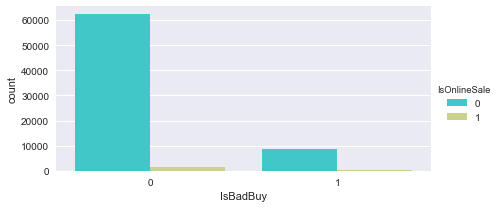

In [26]:
fig7 = sn.factorplot("IsBadBuy",data=df, hue="IsOnlineSale",kind='count', palette="rainbow",size=3,aspect=2)

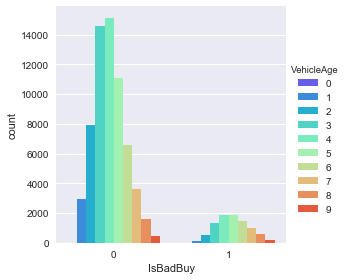

In [27]:
fig8 = sn.factorplot('IsBadBuy',hue='VehicleAge',kind='count',data=df,palette="rainbow") # More 3-4 year cars at IsBadBuy=0 group

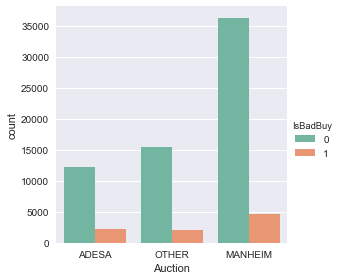

In [28]:
fig9 = sn.factorplot('Auction',hue='IsBadBuy',kind='count',data=df,palette="Set2") # The percentage IsBadBuy among each auction varies

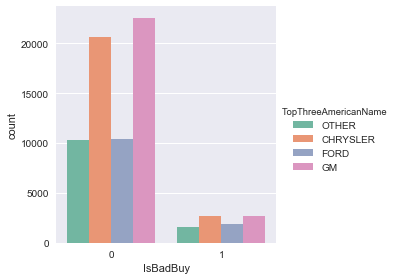

In [29]:
fig10 = sn.factorplot('IsBadBuy',hue='TopThreeAmericanName',kind='count',data=df,palette="Set2")

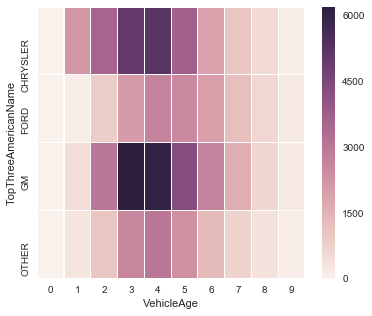

In [30]:
d1=pd.crosstab(index=df.TopThreeAmericanName,columns=df.VehicleAge, margins=False)
plt.figure(figsize=(6,5))
fig11=sn.heatmap(d1,linewidth=0.1)

fig7 to fig11 indicate the possible relation between the Target and the varaibles. Also TopThreeAmericanName cross VehicleAge shows that majority cars are between 2-5 years and belong to GM and CHRYSLER.

  ###  Prepare data for logistic Regression

Scale the huge numerical values

cat = ["Auction","Transmission","Nationality", "TopThreeAmericanName"] <br>
integer = ['IsBadBuy','IsOnlineSale','VehicleAge'] <br>
numeric = [x for x in var_num if x not in integer] # large numeric values <br>

In [31]:
#include all those features in the model
var_all = integer + numeric + cat

df1=df[var_all]

In [32]:
cols_scale= numeric # all the numeric columns need to be scaled

In [33]:
#do log transformation for the large numeric features
def scale_large(df, cols):
    #cols is the list of features columns with large numbers to be scaled
    df[cols]=df[cols].apply(lambda x : np.log(x + 1))# +1 to avoid infinity
    return df
df_scale = scale_large(df1, cols_scale)

C:\ProgramData\Miniconda3\lib\site-packages\pandas\core\frame.py:2440: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


In [34]:
#print(cat,'\n',var_num)

In [35]:
df_scale.columns

Index(['IsBadBuy', 'IsOnlineSale', 'VehicleAge', 'VehOdo',
       'MMRAcquisitionAuctionAveragePrice', 'MMRAcquisitionAuctionCleanPrice',
       'MMRAcquisitionRetailAveragePrice', 'MMRAcquisitonRetailCleanPrice',
       'MMRCurrentAuctionAveragePrice', 'MMRCurrentAuctionCleanPrice',
       'MMRCurrentRetailAveragePrice', 'MMRCurrentRetailCleanPrice', 'BYRNO',
       'VehBCost', 'WarrantyCost', 'Auction', 'Transmission', 'Nationality',
       'TopThreeAmericanName'],
      dtype='object')

 ** Looks like Transmission has some issues bue to a type in the data **

In [36]:
df_scale['Transmission'].value_counts()# here Mannual needs to be fixed

AUTO      70407
MANUAL     2575
Manual        1
Name: Transmission, dtype: int64

In [37]:
#Let's look at which row
typo_index=df_scale[df_scale['Transmission'] =='Manual'].index
df_scale.loc[typo_index,['Transmission']]

,Transmission
RefId,
33118,Manual


In [38]:
df_scale.loc[typo_index,'Transmission'] = 'MANUAL'
#df_new['Transmission']=df_new['Transmission'].replace(to_replace=['Manual'],value='MANUAL')

C:\ProgramData\Miniconda3\lib\site-packages\pandas\core\indexing.py:477: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [39]:
df_scale.Transmission.value_counts()#Now it's good

AUTO      70407
MANUAL     2576
Name: Transmission, dtype: int64

In [40]:
# get dummies for categorical variables
df_new = pd.get_dummies(df_scale,columns=cat)

In [41]:
df_new.head()

,IsBadBuy,IsOnlineSale,VehicleAge,VehOdo,MMRAcquisitionAuctionAveragePrice,MMRAcquisitionAuctionCleanPrice,MMRAcquisitionRetailAveragePrice,MMRAcquisitonRetailCleanPrice,MMRCurrentAuctionAveragePrice,MMRCurrentAuctionCleanPrice,...,Transmission_AUTO,Transmission_MANUAL,Nationality_AMERICAN,Nationality_OTHER,Nationality_OTHER ASIAN,Nationality_TOP LINE ASIAN,TopThreeAmericanName_CHRYSLER,TopThreeAmericanName_FORD,TopThreeAmericanName_GM,TopThreeAmericanName_OTHER
RefId,,,,,,,,,,,,,,,,,,,,,
1,0,0,3,11.396920,9.006509,9.193194,9.361945,9.517899,8.916238,9.054037,...,1,0,0,0,1,0,0,0,0,1
2,0,0,5,11.446722,8.832734,9.034080,9.296335,9.439307,8.916908,9.129456,...,1,0,1,0,0,0,1,0,0,0
3,0,0,4,11.209222,8.071843,8.468213,8.845633,9.042868,8.303009,8.622994,...,1,0,1,0,0,0,1,0,0,0
4,0,0,5,11.091605,7.546446,7.892078,8.446556,8.646641,7.520235,7.881182,...,1,0,1,0,0,0,1,0,0,0
5,0,0,4,11.147181,8.272315,8.528133,8.952088,9.071997,8.085795,8.385945,...,0,1,1,0,0,0,0,1,0,0


In [42]:
#df_new.to_csv("df_new.csv",header=True, sep=',')

 ###   logistic Regression Model

In [43]:
#split X and Y
Y = df_new.iloc[:,0]
X = df_new.iloc[:,1:]
#X.dtypes

In [44]:
# from sklearn.linear_model import LogisticRegression
# from sklearn.linear_model import LogisticRegressionCV
# from sklearn.utils import shuffle
# from sklearn.model_selection import train_test_split
# from sklearn import metrics

In [45]:
# apply logistic regression with L2 penaty
model=LogisticRegression()
model.fit(X,Y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [46]:
model.score(X,Y)#check accuracy on training set

0.8769850513133195

In [47]:
Y.mean()

0.12298754504473644

<font color=green> Y.mean = 0.122, which means we can get 87.8% accuracy by just guessing 0 for all observations. That is exactly the training data accuracy. Basically our model ~ guessing all outcome IsBadBuy=0 <br>
** We need to balance the data for 0 and 1 outcomes using resampling**

In [48]:
df_new['IsBadBuy'].value_counts()

0    64007
1     8976
Name: IsBadBuy, dtype: int64

In [49]:
# define bootstrap and shuffle for the "1" class
def resample(df):
    df0 = df[df['IsBadBuy'] ==0]# 61731 rows
    df1 = df[df['IsBadBuy'] ==1]# 8570 rows
    n_obs = df0.shape[0] # we will resample to get ~61700 samples
    n = df1.shape[0] #originla sample length
    
    # bootstrap from 1 class
    df1_bs = df1.sample(n_obs,replace=True, random_state = 11)

    #df1_bs.shape
    #contatinate df0 and df1_bs
    df_all = pd.concat([df0,df1_bs],ignore_index = True)

    return shuffle(df_all)
    

df_all = resample(df_new)

In [50]:
df_all.shape
df_all['IsBadBuy'].value_counts()

1    64007
0    64007
Name: IsBadBuy, dtype: int64

In [51]:
X, Y = df_all.iloc[:,1:],df_all.iloc[:,0]
xtrain,xtest,ytrain,ytest = train_test_split(X, Y, test_size = 0.3)

** <font color=green> Apply Logistic Regression on training and testing sets and use 5-fold cross validation**

In [52]:
clf = LogisticRegressionCV(cv=5 ,penalty='l2'
    ,scoring='roc_auc', max_iter=100)
clf = clf.fit(xtrain, ytrain)

In [53]:
predicted = clf.predict_proba(xtrain)[:,1]

print('AUC of training set:',metrics.roc_auc_score(ytrain, predicted)) 

AUC of training set: 0.666630936638


In [54]:
print ("testing accuracy: ",metrics.accuracy_score(ytest, clf.predict(xtest)) )

testing accuracy:  0.619242286161


In [55]:
y_pred = clf.predict_proba(xtest)[:,1]

print('AUC of testing set:',metrics.roc_auc_score(ytest, y_pred))

AUC of testing set: 0.664083828653


In [56]:
print(metrics.classification_report(ytest,clf.predict(xtest)))

             precision    recall  f1-score   support

          0       0.62      0.64      0.63     19396
          1       0.62      0.60      0.61     19009

avg / total       0.62      0.62      0.62     38405



In [57]:
#coefficients
pd.DataFrame(np.transpose(clf.coef_), index= xtrain.columns, columns = ['Coefficient Estimation'])

,Coefficient Estimation
IsOnlineSale,-0.088831
VehicleAge,0.240550
VehOdo,0.455960
MMRAcquisitionAuctionAveragePrice,-1.610854
MMRAcquisitionAuctionCleanPrice,0.356180
MMRAcquisitionRetailAveragePrice,1.584213
MMRAcquisitonRetailCleanPrice,-0.390256
MMRCurrentAuctionAveragePrice,1.459920
MMRCurrentAuctionCleanPrice,-0.081053
MMRCurrentRetailAveragePrice,-0.822114


The testing accuracy we got from CV is 0.62, which is slightly better than random guess. AUC we get from testing set is 0.67.
Increasing the VehBCost would decrease the likelihood of being IsBadBuy. Increasing of the VehOdo, VehicleAge would increase the likelihood of being IsBadBuy.

L1 penalty Feature selection is needed in this case for next step

In [58]:
#test data for Kaggle
data_test=pd.read_csv('test.csv',header=0,sep=',',index_col='RefId') #No Y

In [59]:
var_num

['IsBadBuy',
 'VehicleAge',
 'VehOdo',
 'MMRAcquisitionAuctionAveragePrice',
 'MMRAcquisitionAuctionCleanPrice',
 'MMRAcquisitionRetailAveragePrice',
 'MMRAcquisitonRetailCleanPrice',
 'MMRCurrentAuctionAveragePrice',
 'MMRCurrentAuctionCleanPrice',
 'MMRCurrentRetailAveragePrice',
 'MMRCurrentRetailCleanPrice',
 'BYRNO',
 'VehBCost',
 'IsOnlineSale',
 'WarrantyCost']

In [60]:
def fill_missing(df,var_num,var_cat):
#     for var in b_num:
#         df[var].fillna(np.mean(df[var]), inplace=True)
    df[var_num] = df[var_num].apply(lambda x: x.fillna(np.mean(x)))
    df[var_cat] = df[var_cat].apply(lambda x: x.fillna(x.value_counts().index[0]))
    return df        
        
data_test=fill_missing(data_test,var_num[1:], var_categorical)    

df_test=data_test[var_all[1:]]
'''
var_all = integer + numeric + cat
var_num  contains IsbadBuy
'''
#b=data_test.isnull().sum()

# b[b!=0]
# b_num=(b[b!=0].index)[:8]
# b_cat=(b[b!=0].index)[8:]

# data_test['TopThreeAmericanName'].value_counts().index[0]


'\nvar_all = integer + numeric + cat\nvar_num  contains IsbadBuy\n'

In [61]:
#do log transformation for the large numeric features
def scale_large(df, sc):
    #sc is the list of features with large numbers
    df[sc]=df[sc].apply(lambda x : np.log(x + 1))
    return df
df_test_scale = scale_large(df_test, cols_scale)

C:\ProgramData\Miniconda3\lib\site-packages\pandas\core\frame.py:2440: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


In [62]:
df_test_new = pd.get_dummies(df_test_scale, columns=cat)

test_pred = clf.predict(df_test_new)

pd.DataFrame(OrderedDict({'RefId': data_test.index,
              "IsBadBuy": test_pred})).to_csv('submission.csv',index=False)

The submission on Kaggle  indicates the model is very poor wit Gini Index 0.196, which is as we expected......

### Next Step :

> + The missing values could be imputed: VNZIP1,Trim, WheelType, PRIMEUNIT and AUCGUART  <br>

> + Though PurchDate is strongly correlated with VehicleAge, we could create new 'bins'( month, week, days) from the datatime 

> + For the other high-class categorical variables below( the number is the # of classes for each). We might reduce the levels by following their pattern  <br>
 Size 12 <br>
 Make 32 <br>
 Model 962  <br>
 Trim 134   <br>
 SubModel 834   <br>
 Color 16   <br>
 VNST 37    <br>

> + We could check the correlation between the numerical values, remove some of the features are strongly correlated , or combine multiple into one  <br>

> + Apply L1 penalty for feature selection    <br>
> + Tune the model parameters using grid search. <br>

> + PCA could be used to reduce the dimension if obtaining prediction accuracy is our goal, though it will be difficult to intepretate the results  <br>

> + If still not significantly improved, we may want to try other models,like Random Forest, SVM, Gradient Boosting，XGBoost and feedforward neural network. (Logistic Regression assumes linear decision boundary. This may not be the real case for the data)   <br>